### Install and import libararies

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import polars as pl
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor


In [313]:
df = pd.read_csv('data/feature_extract_data.csv')
df.drop(['Title', 'Rating'], axis=1, inplace=True)
df.shape

(3241, 357)

In [159]:
df.corr()['Gross_worldwide'].sort_values(ascending=False)[:20]

Gross_worldwide                         1.000000
Opening_Weekend                         0.764590
Budget                                  0.687660
Theater_counts                          0.366254
studio_Walt Disney Pictures             0.290992
crew_Linda Woolverton                   0.228052
Runtime                                 0.227853
studio_Walt Disney Animation Studios    0.218496
crew_Christopher Markus                 0.215723
Release_Year                            0.214905
actor_Robert Downey Jr.                 0.190468
crew_Jon Favreau                        0.159378
crew_Stan Lee                           0.159162
actor_Ian McKellen                      0.157018
Genre_Adventure                         0.155233
crew_J.K. Rowling                       0.149468
crew_James Cameron                      0.144255
actor_Matthew Broderick                 0.139641
actor_Mark Ruffalo                      0.136803
crew_Fran Walsh                         0.132572
Name: Gross_worldwid

In [149]:
scaler_columns = ['Theater_counts', 'Opening_Weekend', 'Budget']
for col in scaler_columns:
    df[col] = MinMaxScaler().fit_transform(df[col].values.reshape(-1, 1))
df.head()

,Theater_counts,Opening_Weekend,Budget,Runtime,Gross_worldwide,Release_Year,Release_Month,Release_Day,MPAA_G,MPAA_NC-17,...,studio_Relativity Media,studio_Touchstone Pictures,studio_Twentieth Century Fox,studio_Universal Pictures,studio_Village Roadshow Pictures,studio_Walt Disney Animation Studios,studio_Walt Disney Pictures,studio_Warner Bros.,Is_English,Is_United_States
0,0.730525,0.215688,0.665716,162,2847246203,2009,12,18,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.986664,1.000000,1.000000,181,2797501328,2019,4,26,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
2,0.565834,0.080192,0.561779,194,2201647264,1997,12,18,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1
3,0.946867,0.721611,0.901681,149,2048359754,2018,4,25,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,0.904530,0.584703,0.421324,124,1670516444,2015,6,12,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1


In [160]:
def _plot_regression(y_test, y_pred):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title("Comparison")

In [235]:
def print_metric(name, y_train, y_pred_train, y_test, y_pred):
    metrics = {
            "Model": name,
            'MAPE Train (%)': round((mean_absolute_percentage_error(y_train, y_pred_train)), 4),
            'MAPE Test (%)': round((mean_absolute_percentage_error(y_test, y_pred)), 4),
            'MAE Train': round(mean_absolute_error(y_train, y_pred_train), 4),
            'MAE Test': round(mean_absolute_error(y_test, y_pred), 4),
            'R2 Score Train': round(r2_score(y_train, y_pred_train), 4),
            'R2 Score Test': round(r2_score(y_test, y_pred), 4),
        }
    metrics = pl.DataFrame(metrics)
    return metrics

shape: (1, 7)
┌────────────┬────────────────┬───────────┬───────────┬──────────┬──────────┬───────────────┐
│ Model      ┆ MAPE Train (%) ┆ MAPE Test ┆ MAE Train ┆ MAE Test ┆ R2 Score ┆ R2 Score Test │
│ ---        ┆ ---            ┆ (%)       ┆ ---       ┆ ---      ┆ Train    ┆ ---           │
│ str        ┆ f64            ┆ ---       ┆ f64       ┆ f64      ┆ ---      ┆ f64           │
│            ┆                ┆ f64       ┆           ┆          ┆ f64      ┆               │
╞════════════╪════════════════╪═══════════╪═══════════╪══════════╪══════════╪═══════════════╡
│ Linear     ┆ 0.7571         ┆ 0.8831    ┆ 6.1602e7  ┆ 7.1836e7 ┆ 0.7932   ┆ 0.7234        │
│ Regression ┆                ┆           ┆           ┆          ┆          ┆               │
└────────────┴────────────────┴───────────┴───────────┴──────────┴──────────┴───────────────┘


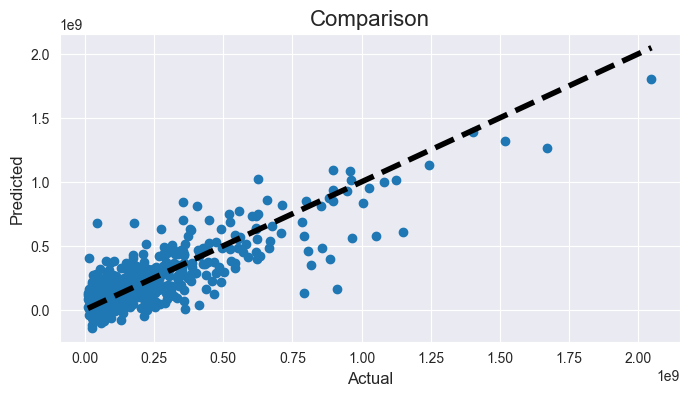

In [358]:
lin = LinearRegression()
train, test = train_test_split(df, test_size=0.3, random_state=31)
    
target = ['Gross_worldwide']
x_train = train.drop('Gross_worldwide', axis=1)
y_train = train[target]
x_test = test.drop('Gross_worldwide', axis=1)
y_test = test[target]
lin.fit(x_train, y_train)
y_predicted = lin.predict(x_test)

_plot_regression(y_test, y_predicted)

lnr_metrics = print_metric("Linear Regression", y_train, lin.predict(x_train), y_test, y_predicted)
print(lnr_metrics)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'alpha': 5}
shape: (1, 7)
┌────────────┬────────────────┬───────────┬───────────┬──────────┬──────────┬───────────────┐
│ Model      ┆ MAPE Train (%) ┆ MAPE Test ┆ MAE Train ┆ MAE Test ┆ R2 Score ┆ R2 Score Test │
│ ---        ┆ ---            ┆ (%)       ┆ ---       ┆ ---      ┆ Train    ┆ ---           │
│ str        ┆ f64            ┆ ---       ┆ f64       ┆ f64      ┆ ---      ┆ f64           │
│            ┆                ┆ f64       ┆           ┆          ┆ f64      ┆               │
╞════════════╪════════════════╪═══════════╪═══════════╪══════════╪══════════╪═══════════════╡
│ Ridge      ┆ 0.7571         ┆ 0.7806    ┆ 6.1602e7  ┆ 6.4347e7 ┆ 0.7932   ┆ 0.7699        │
│ Regression ┆                ┆           ┆           ┆          ┆          ┆               │
└────────────┴────────────────┴───────────┴───────────┴──────────┴──────────┴───────────────┘


d:\Hust Study\Fundament\Machine Learning & Data Mining\Project\Movie Revenue\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.88798e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Hust Study\Fundament\Machine Learning & Data Mining\Project\Movie Revenue\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.88798e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


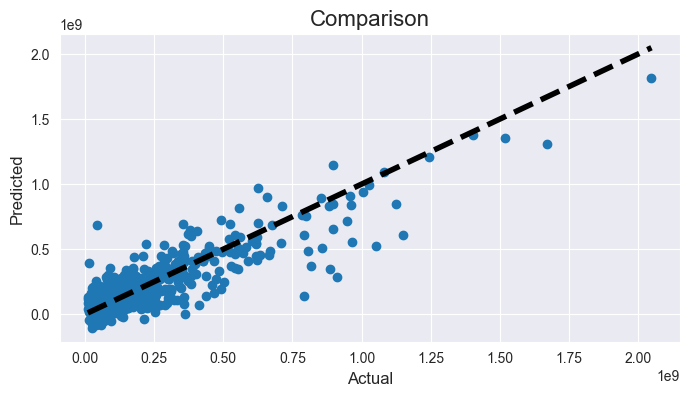

In [361]:
param_grid = {
    'alpha': [0.1, 1, 5],
}
ridge = Ridge()

grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

train, test = train_test_split(df, test_size=0.3, random_state=31)
target = ['Gross_worldwide']
x_train = train.drop('Gross_worldwide', axis=1)
y_train = train[target]
x_test = test.drop('Gross_worldwide', axis=1)
y_test = test[target]

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)
best_model.fit(x_train, y_train)

y_predicted = best_model.predict(x_test)

_plot_regression(y_test, y_predicted)
ridge_metrics = print_metric("Ridge Regression", y_train, lin.predict(x_train), y_test, y_predicted)
print(ridge_metrics)
coefficients = lin.coef_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


d:\Hust Study\Fundament\Machine Learning & Data Mining\Project\Movie Revenue\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'criterion': 'friedman_mse', 'max_depth': 20, 'n_estimators': 300}


d:\Hust Study\Fundament\Machine Learning & Data Mining\Project\Movie Revenue\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


shape: (1, 7)
┌───────────┬────────────┬────────────────┬───────────┬──────────┬────────────────┬────────────────┐
│ Model     ┆ MAPE Train ┆ MAPE Test (%)  ┆ MAE Train ┆ MAE Test ┆ R2 Score Train ┆ R2 Score Test  │
│ ---       ┆ (%)        ┆ ---            ┆ ---       ┆ ---      ┆ ---            ┆ ---            │
│ str       ┆ ---        ┆ f64            ┆ f64       ┆ f64      ┆ f64            ┆ f64            │
│           ┆ f64        ┆                ┆           ┆          ┆                ┆                │
╞═══════════╪════════════╪════════════════╪═══════════╪══════════╪════════════════╪════════════════╡
│ Random    ┆ 0.7449     ┆ 0.5605         ┆ 6.1015e7  ┆ 5.4484e7 ┆ 0.7915         ┆ 0.7904         │
│ Forest    ┆            ┆                ┆           ┆          ┆                ┆                │
│ Regressor ┆            ┆                ┆           ┆          ┆                ┆                │
└───────────┴────────────┴────────────────┴───────────┴──────────┴───────────

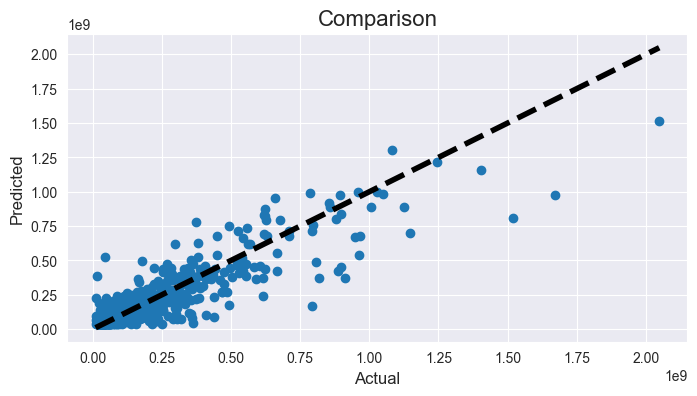

In [322]:
param_grid = {
    'n_estimators': [300],
    'max_depth': [20],
    "criterion": ["friedman_mse"],
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

train, test = train_test_split(df, test_size=0.3, random_state=31)
target = ['Gross_worldwide']
x_train = train.drop('Gross_worldwide', axis=1)
y_train = train[target]
x_test = test.drop('Gross_worldwide', axis=1)
y_test = test[target]

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)
best_model.fit(x_train, y_train)

y_predicted = best_model.predict(x_test)
_plot_regression(y_test, y_predicted)

rf_metrics = print_metric("Random Forest Regressor", y_train, lin.predict(x_train), y_test, y_predicted)
print(rf_metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


d:\Hust Study\Fundament\Machine Learning & Data Mining\Project\Movie Revenue\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 300}


d:\Hust Study\Fundament\Machine Learning & Data Mining\Project\Movie Revenue\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


shape: (1, 7)
┌─────────────────┬─────────────────┬───────────┬───────────┬──────────┬──────────┬────────────────┐
│ Model           ┆ MAPE Train (%)  ┆ MAPE Test ┆ MAE Train ┆ MAE Test ┆ R2 Score ┆ R2 Score Test  │
│ ---             ┆ ---             ┆ (%)       ┆ ---       ┆ ---      ┆ Train    ┆ ---            │
│ str             ┆ f64             ┆ ---       ┆ f64       ┆ f64      ┆ ---      ┆ f64            │
│                 ┆                 ┆ f64       ┆           ┆          ┆ f64      ┆                │
╞═════════════════╪═════════════════╪═══════════╪═══════════╪══════════╪══════════╪════════════════╡
│ AdaBoostRegress ┆ 0.7449          ┆ 0.9297    ┆ 6.1015e7  ┆ 7.2438e7 ┆ 0.7915   ┆ 0.6896         │
│ or              ┆                 ┆           ┆           ┆          ┆          ┆                │
└─────────────────┴─────────────────┴───────────┴───────────┴──────────┴──────────┴────────────────┘


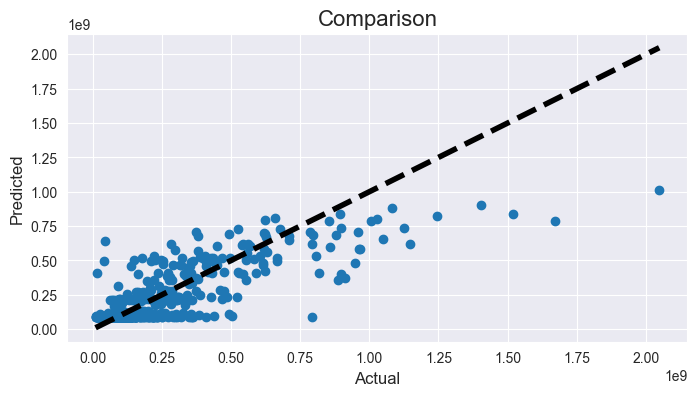

In [323]:
ada_params = {
    'n_estimators': [100,200,300,500],
    'learning_rate': [0.1,0.01],
    'loss': ['linear', 'square', 'exponential'],
}

ada = AdaBoostRegressor()
grid_search = GridSearchCV(estimator=ada, param_grid=ada_params, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)
best_model.fit(x_train, y_train)

y_predicted = best_model.predict(x_test)
_plot_regression(y_test, y_predicted)

ada_metrics = print_metric("AdaBoostRegressor", y_train, lin.predict(x_train), y_test, y_predicted)
print(ada_metrics)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.5}
shape: (1, 7)
┌──────────────┬────────────────┬───────────┬───────────┬──────────┬──────────┬───────────────┐
│ Model        ┆ MAPE Train (%) ┆ MAPE Test ┆ MAE Train ┆ MAE Test ┆ R2 Score ┆ R2 Score Test │
│ ---          ┆ ---            ┆ (%)       ┆ ---       ┆ ---      ┆ Train    ┆ ---           │
│ str          ┆ f64            ┆ ---       ┆ f64       ┆ f64      ┆ ---      ┆ f64           │
│              ┆                ┆ f64       ┆           ┆          ┆ f64      ┆               │
╞══════════════╪════════════════╪═══════════╪═══════════╪══════════╪══════════╪═══════════════╡
│ XGBRegressor ┆ 0.7449         ┆ 0.579     ┆ 6.1015e7  ┆ 5.4467e7 ┆ 0.7915   ┆ 0.8021        │
└──────────────┴────────────────┴───────────┴───────────┴──────────┴──────────┴─────────────

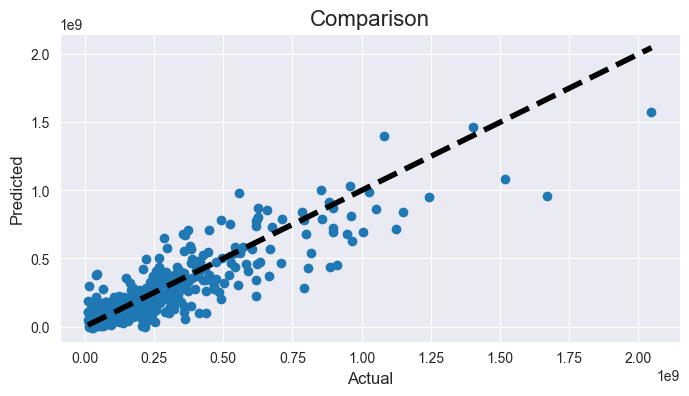

In [325]:
xgb_params = {
    'learning_rate': [0.1, 0.01],  
    'max_depth': [15, 20, None],        
    'n_estimators' : [200, 300, 400],
    'min_child_weight': [3, 5], 
    'subsample': [0.3, 0.5, 0.7],      
    'colsample_bytree': [0.5, 0.7, 0.9],  
    'objective': ['reg:squarederror']
}

xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print(grid_search.best_params_)
best_model.fit(x_train, y_train)

y_predicted = best_model.predict(x_test)
_plot_regression(y_test, y_predicted)

xgb_metrics = print_metric("XGBRegressor", y_train, lin.predict(x_train), y_test, y_predicted)
print(xgb_metrics)

In [362]:
all_metrics = pl.concat([lnr_metrics, ridge_metrics, rf_metrics, ada_metrics, xgb_metrics])
print(all_metrics)

shape: (5, 7)
┌─────────────────┬─────────────────┬───────────┬───────────┬──────────┬──────────┬────────────────┐
│ Model           ┆ MAPE Train (%)  ┆ MAPE Test ┆ MAE Train ┆ MAE Test ┆ R2 Score ┆ R2 Score Test  │
│ ---             ┆ ---             ┆ (%)       ┆ ---       ┆ ---      ┆ Train    ┆ ---            │
│ str             ┆ f64             ┆ ---       ┆ f64       ┆ f64      ┆ ---      ┆ f64            │
│                 ┆                 ┆ f64       ┆           ┆          ┆ f64      ┆                │
╞═════════════════╪═════════════════╪═══════════╪═══════════╪══════════╪══════════╪════════════════╡
│ Linear          ┆ 0.7571          ┆ 0.8831    ┆ 6.1602e7  ┆ 7.1836e7 ┆ 0.7932   ┆ 0.7234         │
│ Regression      ┆                 ┆           ┆           ┆          ┆          ┆                │
│ Ridge           ┆ 0.7571          ┆ 0.7806    ┆ 6.1602e7  ┆ 6.4347e7 ┆ 0.7932   ┆ 0.7699         │
│ Regression      ┆                 ┆           ┆           ┆          ┆     